In [1]:
import torch

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
from sklearn.datasets import make_moons

N_SAMPLES = 1000
DATA_NOISE = 0.1
RANDOM_SEED = 42

X, y = make_moons(n_samples=N_SAMPLES, noise=DATA_NOISE, random_state=RANDOM_SEED)

X[:5], y[:5], X[:5, 0]

(array([[-0.05146968,  0.44419863],
        [ 1.03201691, -0.41974116],
        [ 0.86789186, -0.25482711],
        [ 0.288851  , -0.44866862],
        [-0.83343911,  0.53505665]]),
 array([1, 1, 1, 1, 0], dtype=int64),
 array([-0.05146968,  1.03201691,  0.86789186,  0.288851  , -0.83343911]))

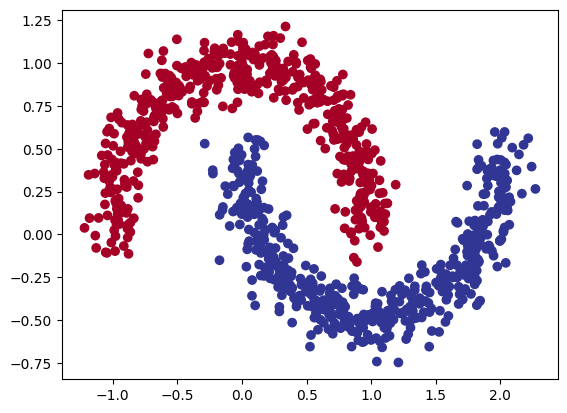

In [4]:
import matplotlib.pyplot as plt

plt.scatter(x=X[:,0], y=X[:,1], c=y, cmap=plt.cm.RdYlBu)

In [5]:
X = torch.tensor(X).float()
y = torch.tensor(y).float()

In [6]:
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

len(X_tr), len(X_te), len(y_tr), len(y_te)

(800, 200, 800, 200)

In [7]:
X_tr = X_tr.to(device)
X_te = X_te.to(device)
y_tr = y_tr.to(device)
y_te = y_te.to(device)

In [8]:
from torch import nn
import numpy as np

torch.manual_seed(420)

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=2, out_features=10),
            nn.Tanh(),
            nn.Linear(in_features=10, out_features=5),
            nn.Tanh(),
            nn.Linear(in_features=5, out_features=1),
        )

    def forward(self, x):
        return self.layer_stack(x)

In [9]:
model = Model().to(device)
model

Model(
  (layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Tanh()
    (2): Linear(in_features=10, out_features=5, bias=True)
    (3): Tanh()
    (4): Linear(in_features=5, out_features=1, bias=True)
  )
)

In [10]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.1)

In [11]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    return (correct / len(y_true)) * 100

In [12]:
iterations = 40 

for i in range(iterations):
    model.train()

    logits = model(X_tr).squeeze()
    logits_pred = torch.round(torch.sigmoid(logits))

    acc = accuracy_fn(y_true=y_tr, y_pred=logits_pred)
    loss = loss_fn(logits, y_tr)

    optimizer.zero_grad()
    
    loss.backward()

    optimizer.step()

    if i % 5 == 0:
        model.eval()
        with torch.inference_mode():
            test_logits = model(X_te).squeeze()
            test_logits_pred = torch.round(torch.sigmoid(test_logits))

            test_loss = loss_fn(test_logits, y_te)
            test_acc = accuracy_fn(y_true=y_te, y_pred=test_logits_pred)

        print(f'Iteration {i}: LOSS: {loss:.5f} | ACCURACY: {acc:.1f}% | TEST_LOSS: {test_loss:.5f} | TEST ACCURACY: {test_acc:.1f}%')
        
print(f'Iteration {i+1}: LOSS: {loss:.5f} | ACCURACY: {acc:.1f}% | TEST_LOSS: {test_loss:.5f} | TEST ACCURACY: {test_acc:.1f}%')


Iteration 0: LOSS: 0.69539 | ACCURACY: 50.0% | TEST_LOSS: 0.58965 | TEST ACCURACY: 73.5%
Iteration 5: LOSS: 0.33032 | ACCURACY: 86.1% | TEST_LOSS: 0.29854 | TEST ACCURACY: 87.0%
Iteration 10: LOSS: 0.31941 | ACCURACY: 86.8% | TEST_LOSS: 0.28324 | TEST ACCURACY: 89.0%
Iteration 15: LOSS: 0.26018 | ACCURACY: 88.4% | TEST_LOSS: 0.23400 | TEST ACCURACY: 90.0%
Iteration 20: LOSS: 0.22029 | ACCURACY: 91.8% | TEST_LOSS: 0.21016 | TEST ACCURACY: 94.0%
Iteration 25: LOSS: 0.13441 | ACCURACY: 94.9% | TEST_LOSS: 0.10685 | TEST ACCURACY: 97.0%
Iteration 30: LOSS: 0.06255 | ACCURACY: 99.0% | TEST_LOSS: 0.04439 | TEST ACCURACY: 99.5%
Iteration 35: LOSS: 0.02945 | ACCURACY: 99.6% | TEST_LOSS: 0.02041 | TEST ACCURACY: 100.0%
Iteration 40: LOSS: 0.01779 | ACCURACY: 99.8% | TEST_LOSS: 0.02041 | TEST ACCURACY: 100.0%


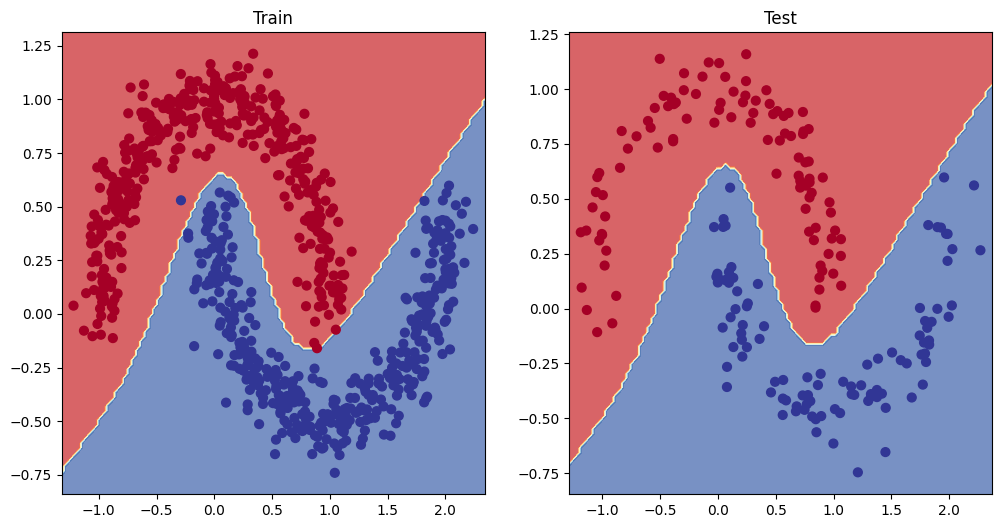

In [13]:
from helper_functions import plot_predictions, plot_decision_boundary

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_tr, y_tr)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_te, y_te)